In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.expected_conditions import url_changes

from bs4 import BeautifulSoup
import requests

import pandas as pd
import time

##### Ouverture du site booking.com avec Selenium

In [2]:
driver = webdriver.Chrome()

driver.get("https://booking.com")

data = []

current_url = driver.current_url

##### Acceptation des cookies

In [3]:
accept_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler"))
    )
accept_button.click()

##### Recherche des hébergements sur Paris

- Récupération de la date du jour pour la date d'hébergement

In [4]:
import locale
from datetime import datetime, timedelta

locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

today = datetime.today()
formatted_date = today.strftime("%d %B %Y")

formatted_date = formatted_date.replace(formatted_date.split()[1], formatted_date.split()[1].capitalize())

tomorrow = today + timedelta(days=1)
formatted_tomorrow = tomorrow.strftime("%d %B %Y")

formatted_tomorrow = formatted_tomorrow.replace(formatted_tomorrow.split()[1], formatted_tomorrow.split()[1].capitalize())

print(formatted_date)
print(formatted_tomorrow)

18 Novembre 2024
19 Novembre 2024


- Recherche des hébergements sur Paris pour la date du jour

In [5]:
search_box = WebDriverWait(driver, 10).until(
   EC.presence_of_element_located((By.NAME, "ss"))
)

search_box.send_keys("Paris")

search_button = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable(
        (By.XPATH, "//button[.//span[text()='Rechercher']]")
    )
)

date_button = WebDriverWait(driver, 2).until(
    EC.element_to_be_clickable(
        (By.XPATH, "//button[@data-testid='date-display-field-start']")
    )
)

date_button.click()

driver.find_element(By.XPATH, f"//span[@aria-label='{formatted_date}']").click()
driver.find_element(By.XPATH, f"//span[@aria-label='{formatted_tomorrow}']").click()

search_button.click()

WebDriverWait(driver, 10).until(url_changes(current_url))

True

##### Fermeture de la pop-up

In [6]:
pop_up_element = WebDriverWait(driver, 10).until(
    EC.visibility_of_element_located((By.XPATH, "//div[@class='eb33ef7c47']"))
)

close_button = driver.find_element(By.CSS_SELECTOR, "div.abcc616ec7 button[aria-label='Ignorer les infos relatives à la connexion']")
close_button.click()

##### Affichage de tous les hébergements disponibles

In [7]:
buttonNotLoaded = True

while buttonNotLoaded:
    try:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        load_more_button = driver.find_element(By.CSS_SELECTOR, "div[data-results-container='1'] > :last-child > button")
        print("Stop scrolling!")
        buttonNotLoaded = False
    except:
        print("Keep scrolling...")

while True:
    try:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        load_more_button = driver.find_element(By.XPATH, "//button[.//span[text()='Afficher plus de résultats']]")

        load_more_button.click()
        time.sleep(1)
    except Exception as e:
        print("Erreur : ", e)
        break


Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Keep scrolling...
Stop scrolling!
Erreur :  Message: no such element: Unable to locate element: {"method":"xpath","selector":"//button[.//span[text()='Afficher plus de résultats']]"}
  (Session info: chrome=131.0.6778.69); For documentation on this error, please visit: https://ww

##### Récupération des hébergements

In [8]:
property_cards = WebDriverWait(driver, 10).until(
    EC.presence_of_all_elements_located((By.XPATH, "//div[@data-testid='property-card']"))
)

In [9]:
i=0

for card in property_cards:
    i+=1

i

999

Parcours de chaque hebergements et recuperations des notes par catégories

In [11]:
list_links = []
for card in property_cards:
    link = card.find_element(By.CSS_SELECTOR, "a[data-testid='title-link']").get_attribute("href")
    title = card.find_element(By.CSS_SELECTOR, "div[data-testid='title']").text
    arrondissement = card.find_element(By.CSS_SELECTOR, "span[data-testid='address']").text
    tarif_text = card.find_element(By.CSS_SELECTOR, "span[data-testid='price-and-discounted-price']").text
    tarif_text = tarif_text.replace("€", "")
    tarif_text = tarif_text.replace(" ", "")
    tarif = int(tarif_text)
    list_links.append([title, link, arrondissement, tarif])

for hotel_title, link, arrondissement, tarif in list_links:
    try:

        response = requests.get(link)
        soup = BeautifulSoup(response.content, 'html.parser')

        try:
            adresse_element = soup.select_one("span.hp_address_subtitle")
            adresse = adresse_element.get_text(strip=True) if adresse_element else ""
        except Exception as e:
            print(f"Erreur lors de l'extraction de l'adresse pour {hotel_title}: {e}")
            adresse = ""


        try:
            description_elements = soup.select("[data-testid='property-description']")
            description = " ".join([element.get_text(strip=True) for element in description_elements])
        except Exception as e:
            print(f"Erreur lors de l'extraction de la description pour {hotel_title}: {e}")
            description = ""

        try:
            points_fort_elements = soup.select("[data-testid='property-most-popular-facilities-wrapper'] ul li")
            points_fort = [points_fort.get_text(strip=True) for points_fort in points_fort_elements]
        except Exception as e:
            print(f"Erreur lors de l'extraction des points forts pour {hotel_title}: {e}")
            points_fort = []

        reviews = soup.select("div[data-testid='review-subscore']")
        notes = []

        for review in reviews:
            title = review.select_one("span.be887614c2")
            score = review.select_one("div.ccb65902b2.bdc1ea4a28")
            if title and score:
                notes.append({
                    "title_text": title.get_text(strip=True),
                    "score_text": score.get_text(strip=True)
                })

 
        comments = soup.select("li.b0932df2e7")
        hotel_comments = []

        for comment in comments:
            try:
                name = comment.select_one("div.a3332d346a").get_text(strip=True)
                comment_text = comment.select_one("div.a53cbfa6de").get_text(strip=True)
                hotel_comments.append({
                    'Nom': name,
                    'Commentaire': comment_text
                })
            except AttributeError as e:
                print(f"Erreur lors de l'extraction d'un commentaire pour {hotel_title}: {e}")


        data.append({
            "titre": hotel_title,
            "lien_hotel": link,
            "arrondissement": arrondissement,
            "adresse": adresse,
            "description": description,
            "points_fort": points_fort,
            "notes": notes,
            "hotel_comments": hotel_comments,
            "tarif": tarif
        })

    except requests.RequestException as e:
        print(f"Erreur de téléchargement pour {link}: {e}")


Erreur lors de l'extraction d'un commentaire pour Pullman Paris Tour Eiffel: 'NoneType' object has no attribute 'get_text'
Erreur lors de l'extraction d'un commentaire pour La Finca Hôtel & Spa: 'NoneType' object has no attribute 'get_text'
Erreur lors de l'extraction d'un commentaire pour Hôtel Dame des Arts: 'NoneType' object has no attribute 'get_text'
Erreur lors de l'extraction d'un commentaire pour Hôtel Dame des Arts: 'NoneType' object has no attribute 'get_text'
Erreur lors de l'extraction d'un commentaire pour Hôtel National Des Arts et Métiers: 'NoneType' object has no attribute 'get_text'
Erreur lors de l'extraction d'un commentaire pour Miiro Le Grand Hôtel Cayré: 'NoneType' object has no attribute 'get_text'
Erreur lors de l'extraction d'un commentaire pour Hôtel Montecristo: 'NoneType' object has no attribute 'get_text'
Erreur lors de l'extraction d'un commentaire pour Paris j'Adore Hotel & Spa: 'NoneType' object has no attribute 'get_text'
Erreur lors de l'extraction d'u

##### Fermeture de la page avec Selenium

In [ ]:
#driver.quit()

##### Création du dataframe et ajout au fichier csv

In [64]:
df = pd.DataFrame(data, columns=["titre", "lien_hotel","arrondissement","adresse","description","points_fort","notes", "hotel_comments", "tarif"])
df.to_csv("booking.csv", index=False)

In [ ]:
df

##### Ajout à la base de données (SQLite & MongoDB)

In [14]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["booking_db"]
collection = db["hebergements"]

collection.insert_many(df.to_dict(orient='records'))

InsertManyResult([ObjectId('673b27fbcfa74ecdef385b4c'), ObjectId('673b27fbcfa74ecdef385b4d'), ObjectId('673b27fbcfa74ecdef385b4e'), ObjectId('673b27fbcfa74ecdef385b4f'), ObjectId('673b27fbcfa74ecdef385b50'), ObjectId('673b27fbcfa74ecdef385b51'), ObjectId('673b27fbcfa74ecdef385b52'), ObjectId('673b27fbcfa74ecdef385b53'), ObjectId('673b27fbcfa74ecdef385b54'), ObjectId('673b27fbcfa74ecdef385b55'), ObjectId('673b27fbcfa74ecdef385b56'), ObjectId('673b27fbcfa74ecdef385b57'), ObjectId('673b27fbcfa74ecdef385b58'), ObjectId('673b27fbcfa74ecdef385b59'), ObjectId('673b27fbcfa74ecdef385b5a'), ObjectId('673b27fbcfa74ecdef385b5b'), ObjectId('673b27fbcfa74ecdef385b5c'), ObjectId('673b27fbcfa74ecdef385b5d'), ObjectId('673b27fbcfa74ecdef385b5e'), ObjectId('673b27fbcfa74ecdef385b5f'), ObjectId('673b27fbcfa74ecdef385b60'), ObjectId('673b27fbcfa74ecdef385b61'), ObjectId('673b27fbcfa74ecdef385b62'), ObjectId('673b27fbcfa74ecdef385b63'), ObjectId('673b27fbcfa74ecdef385b64'), ObjectId('673b27fbcfa74ecdef385b

##### Chargement des données (dans le cas où le notebook aurait été fermé)

In [66]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["booking_db"]
collection = db["hebergements"]

documents = collection.find()

df = pd.DataFrame(list(documents))
df = df.drop(columns= "_id")

##### Visualisation des données

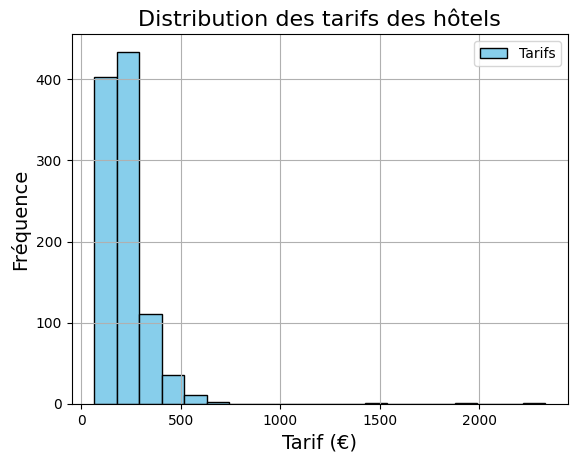

In [69]:
import matplotlib.pyplot as plt

df['tarif'].hist(bins=20, color='skyblue', edgecolor='black', label='Tarifs')
plt.title('Distribution des tarifs des hôtels', fontsize=16)
plt.xlabel('Tarif (€)', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.legend()
plt.show()

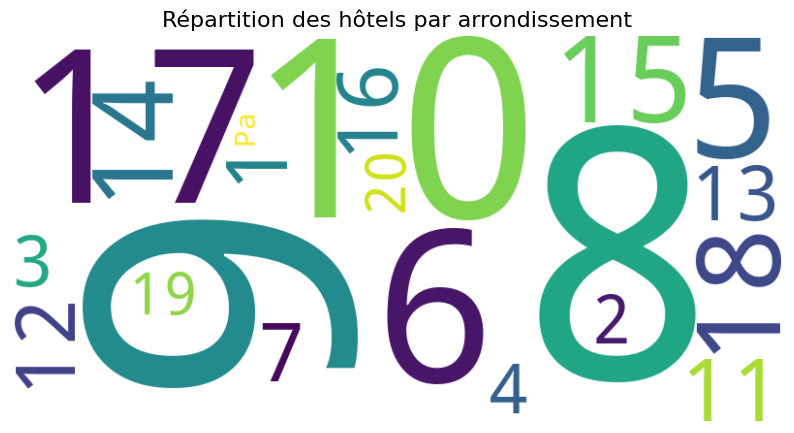

In [71]:
df['arrondissement'] = df['arrondissement'].str[:2].str.replace('e', '', regex=False)
from wordcloud import WordCloud
import matplotlib.pyplot as plt


arrondissement_counts = df['arrondissement'].value_counts().to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(arrondissement_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Répartition des hôtels par arrondissement', fontsize=16)
plt.show()

#### Machine Learning

##### Analyse des sentiments

In [17]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Paul\AppData\Roaming\nltk_data...


True

In [ ]:
commentaires = []

for comments in df['hotel_comments']:
    for comment in comments:
        commentaires.append(comment['Commentaire'])

commentaires = [comment.replace(r'[^a-zA-Z\s]', '').lower().strip() for comment in commentaires]

commentaires

['«j’ai beaucoup apprécié le calme de l’établissement, inattendu à deux pas du moulin rouge, la belle chambre, la jolie décoration, la literie impeccable et la propreté. un accueil très agréable mais pas obséquieux, ce qui est à noter favorablement.»',
 '«nous avons tout aimé et particulièrement cette magnifique salle de bain \nle personnel est extrêmement sympathique accueillant et disponible \nil mérite amplement ses 5 etoiles»',
 '«endroit parfaitement situé, qualité des services au top. personnel aux petits soins.»',
 '«accueil très sympathique et professionnel très bel hôtel familial rénover avec beaucoup de goût et de tres haute gamme dans les matériaux choisis avec goût et harmonie des couleurs mérite grandement ses cinq belles étoiles ont aurait envie de...»',
 '«la dame qui nous accueille est charmante, la chambre est bien.»',
 "«la décoration raffinée, le style cosy et chaleureux, le confort exceptionnel de la literie, l'insonorisation de qualité, la gentillesse et la disponi

In [19]:
sia = SentimentIntensityAnalyzer()
sentiments = [sia.polarity_scores(comment)['compound'] for comment in commentaires]

for comment, sentiment in zip(commentaires, sentiments):
    print(f"Commentaire : {comment}")
    print(f"Sentiment : {sentiment}")
    print()

Commentaire : «j’ai beaucoup apprécié le calme de l’établissement, inattendu à deux pas du moulin rouge, la belle chambre, la jolie décoration, la literie impeccable et la propreté. un accueil très agréable mais pas obséquieux, ce qui est à noter favorablement.»
Sentiment : 0.0

Commentaire : «nous avons tout aimé et particulièrement cette magnifique salle de bain 
le personnel est extrêmement sympathique accueillant et disponible 
il mérite amplement ses 5 etoiles»
Sentiment : -0.128

Commentaire : «endroit parfaitement situé, qualité des services au top. personnel aux petits soins.»
Sentiment : 0.2023

Commentaire : «accueil très sympathique et professionnel très bel hôtel familial rénover avec beaucoup de goût et de tres haute gamme dans les matériaux choisis avec goût et harmonie des couleurs mérite grandement ses cinq belles étoiles ont aurait envie de...»
Sentiment : 0.0

Commentaire : «la dame qui nous accueille est charmante, la chambre est bien.»
Sentiment : 0.0

Commentaire :

##### Prédiction du prix

- Chargement du dataframe de la base mongoDB

In [54]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["booking_db"]
collection = db["hebergements"]

documents = collection.find()

df_predictions = pd.DataFrame(list(documents))
df_predictions = df_predictions.drop(columns= "_id")

In [55]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


- Transformation des données pour les prédictions (points forts, arrondissements et note moyenne)

In [56]:

all_points_forts = set([point for sublist in df_predictions['points_fort'] for point in sublist])

for point in all_points_forts:
    df_predictions[point] = df_predictions['points_fort'].apply(lambda points: 1 if point in points else 0)

def extract_average_score(notes):
    try:
        scores = [float(note['score_text'].replace(',', '.')) for note in notes if 'score_text' in note]
        return sum(scores) / len(scores) if scores else None
    except Exception as e:
        print(f"Erreur lors de l'extraction des notes : {e}")
        return None

df_predictions['average_score'] = df_predictions['notes'].apply(extract_average_score)


def extract_arrondissement(arrondissement_str):
    try:
        return int(''.join(filter(str.isdigit, arrondissement_str)))
    except:
        return None

df_predictions['arrondissement_num'] = df_predictions['arrondissement'].apply(extract_arrondissement)


- Création du tableau avec les valeurs à analyser et de celui avec la valeur cible

In [57]:

X = df_predictions.drop(columns=['tarif', 'titre', 'lien_hotel', 'adresse', 'description', 'hotel_comments', 'points_fort', 'notes', 'arrondissement'])

X['arrondissement_num'] = X['arrondissement_num'].fillna(X['arrondissement_num'].median())

X = X.fillna(X.median())

y = df_predictions['tarif']

- Répartition des données d'entraînement et de test

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Utilisation du modèle de régression linéaire

In [59]:

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [60]:
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 20383.382506731272
R^2 Score: 0.33557061791027154


In [ ]:
resultat = pd.DataFrame({'Réel': y_test, 'Prédiction': y_pred})
print(resultat)

     Réel  Prédiction
453   202  222.016533
793   244  203.372453
209   111  105.235403
309   197  194.762285
740   216  204.528708
..    ...         ...
78    115  192.533479
29    406  454.313689
277   149  197.016255
261   120  135.659955
423   200  291.464863

[200 rows x 2 columns]
